In [51]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from pygam import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score


In [3]:
# To see all columns
pd.set_option('display.max_columns', None)

# Importing and Cleaning Data

In [4]:
# Importing data
pitches_22 = pd.read_csv('updated_pitches_22_1.csv')
pitches_23 = pd.read_csv('updated_pitches_23_1.csv')
pitches_24 = pd.read_csv('updated_pitches_24_1.csv')

# Combine them
pitches_total = pd.concat([pitches_22, pitches_23, pitches_24])

In [5]:
# Organizing rows by game, at bat
pitches_total_sorted = pitches_total.sort_values(['gameid', 'ab', 'pitchnum']).reset_index(drop=True)

In [6]:
# Filtering out position pitchers pitching
# If a pitcher ever hit as well, they are likely a position player
# Will also use some more filtering to ensure Ohtani is included
pitchers = pitches_total_sorted['pitcher'].unique()  # pitcher column contains MLBAM IDs
batters = pitches_total_sorted['batter'].unique()

# Edge case for Ohtani, any other known pitcher that somehow hit
pitch_counts = pitches_total_sorted['pitcher'].value_counts()
valid_pitchers = set(pitch_counts[pitch_counts > 200].index)

pitches_total_sorted = pitches_total_sorted[(~pitches_total_sorted['pitcher'].isin(batters)) |
                                            (pitches_total_sorted['pitcher'].isin(valid_pitchers))].reset_index(drop=True)


In [7]:
# Remove any Statcast errors in release speed (may need to filter out more errors)
pitches_total_sorted = (pitches_total_sorted[(pitches_total_sorted['relspeed'] > 50) &
                                             (pitches_total_sorted['relspeed'] < 108)]).reset_index(drop=True)

We want to work with grounded into double play batted ball profiles, so let's filter for plays where there was a 
grounded into double play

# Finding Most Optimal GIDP Contact -- MULTIPLE TYPES

In [8]:
dps = pitches_total_sorted[pitches_total_sorted['eventtype'] == 'grounded_into_double_play']
# We have ~10,000 instances of GIDP, so we can work with this

In [9]:
# 10,005 grounded into double plays instances
len(dps)

10005

<Axes: xlabel='ExitSpeed', ylabel='Density'>

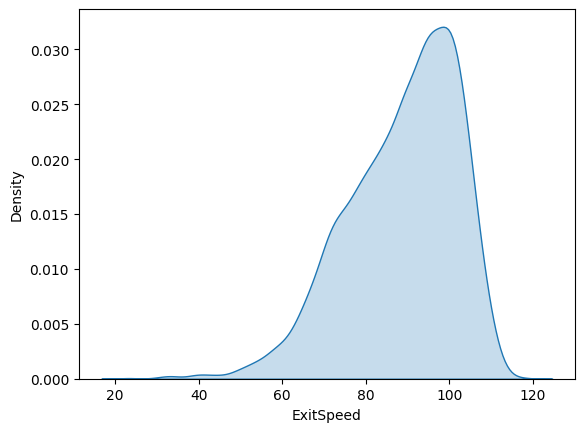

In [10]:
# GIDP batted ball profile distributions 
sns.kdeplot(dps['ExitSpeed'], fill=True)

In [11]:
np.mean(dps['ExitSpeed']), np.nanmedian(dps['ExitSpeed'])

(np.float64(88.63305389825408), np.float64(90.858215))

<Axes: xlabel='ExitSpeed', ylabel='Density'>

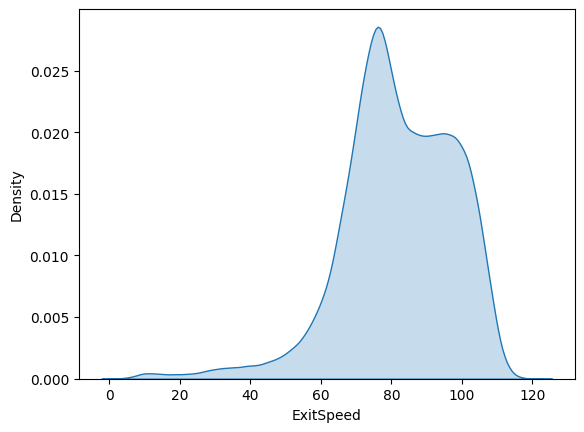

In [12]:
sns.kdeplot(pitches_total_sorted['ExitSpeed'], fill=True)

<Axes: xlabel='VExitAngle', ylabel='Density'>

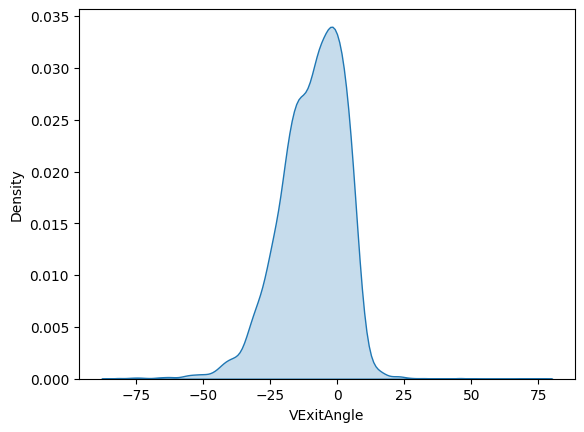

In [13]:
sns.kdeplot(dps['VExitAngle'], fill=True)

<Axes: xlabel='HExitAngle', ylabel='Density'>

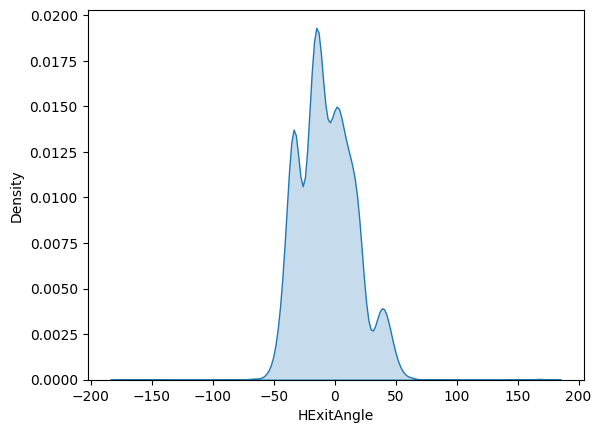

In [14]:
sns.kdeplot(dps['HExitAngle'], fill=True)

<Axes: xlabel='HExitAngle', ylabel='Density'>

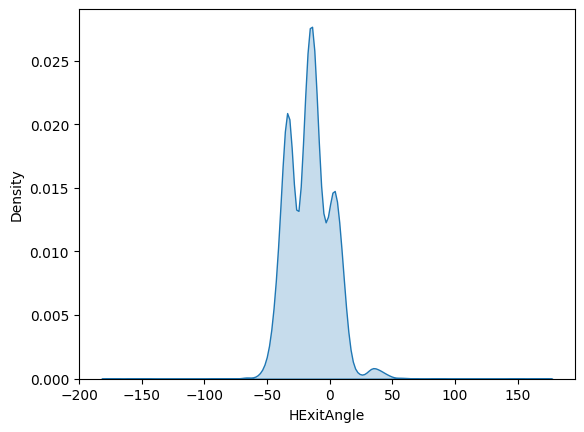

In [15]:
# Right handed hitters HExitAngle
sns.kdeplot(dps[dps['batterside'] == 'R']['HExitAngle'], fill=True)


<Axes: xlabel='HExitAngle', ylabel='Density'>

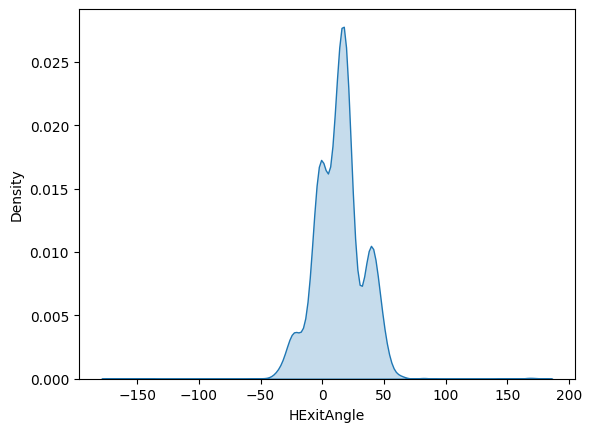

In [16]:
sns.kdeplot(dps[dps['batterside'] == 'L']['HExitAngle'], fill=True)

## Right-handed Hitters Optimal GIDP Contact

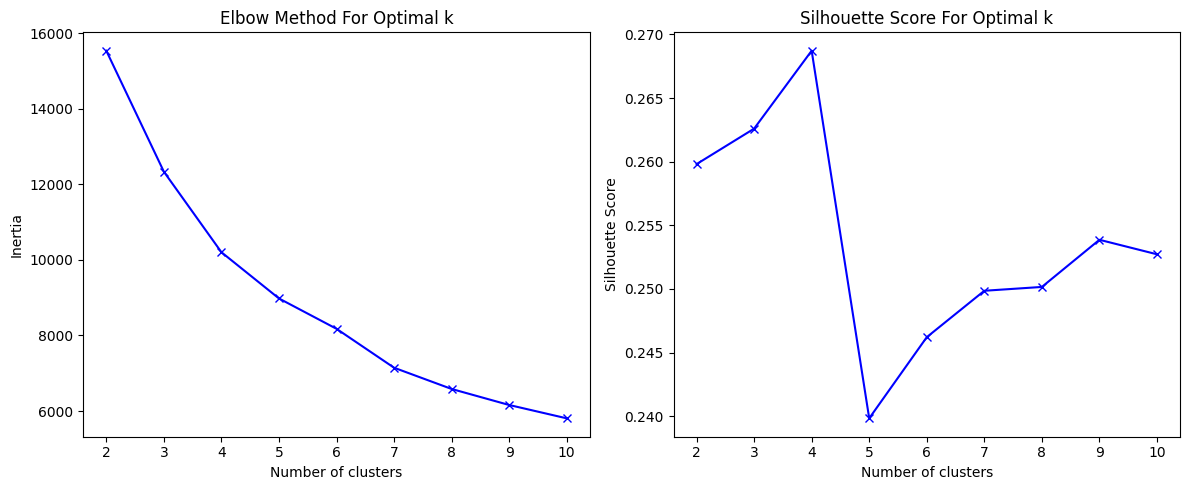

In [17]:
X_right = dps[dps['batterside'] == 'R'][['ExitSpeed', 'VExitAngle', 'HExitAngle']].dropna()

# Scale data
scaler_right = StandardScaler()
X_right_scaled = scaler_right.fit_transform(X_right)
# Determine optimal number of clusters using the elbow method and silhouette score
inertia = []
silhouette_scores = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_right_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_right_scaled, kmeans.labels_))

# Plotting the elbow method
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')

# Plotting the silhouette scores
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')
plt.tight_layout()
plt.show()

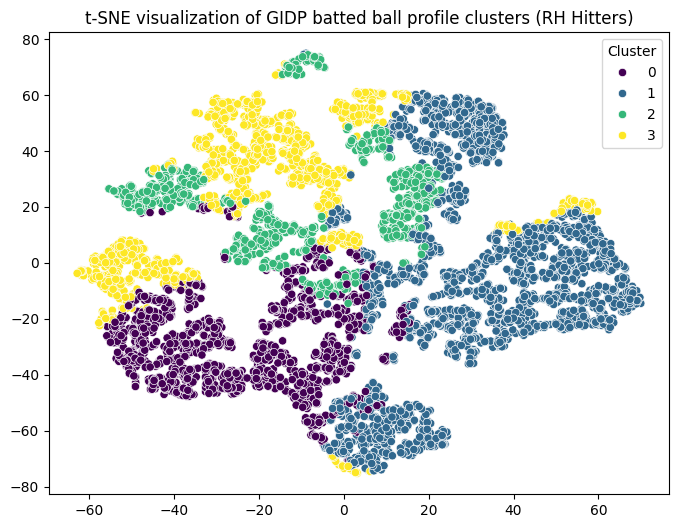

In [18]:
k = 4
kmeans_right = KMeans(n_clusters=k, n_init=50, random_state=42)
X_right['Cluster'] = kmeans_right.fit_predict(X_right_scaled)

tsne_right = TSNE(
    n_components=2, # 2D projection
    perplexity=40, # 30-50 is good here
    random_state=1236,
    n_jobs=-1
)

X_tsne_right = tsne_right.fit_transform(X_right_scaled)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne_right[:, 0], y=X_tsne_right[:, 1], hue=X_right['Cluster'], palette='viridis')
plt.title('t-SNE visualization of GIDP batted ball profile clusters (RH Hitters)')
plt.show()

## Left-handed Hitters Optimal GIDP Contact

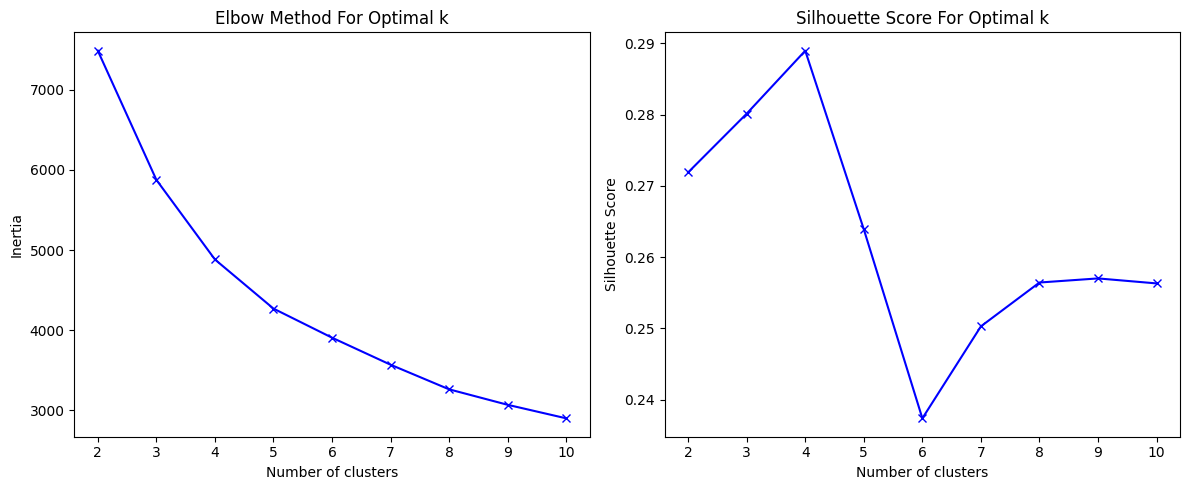

In [19]:
X_left = dps[dps['batterside'] == 'L'][['ExitSpeed', 'VExitAngle', 'HExitAngle']].dropna()
# Determine optimal number of clusters using the elbow method and silhouette score
# Scale data
scaler_left = StandardScaler()
X_left_scaled = scaler_left.fit_transform(X_left)
inertia = []
silhouette_scores = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_left_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_left_scaled, kmeans.labels_))

# Plotting the elbow method
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
# Plotting the silhouette scores
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')
plt.tight_layout()
plt.show()

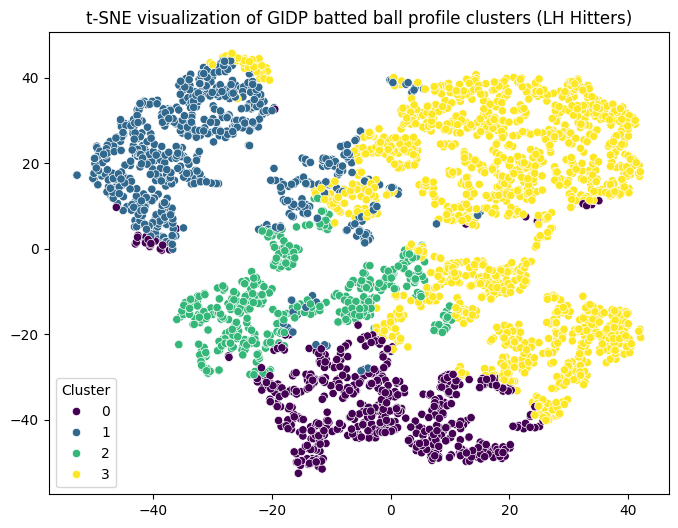

In [20]:
# K is 5 
k = 4
kmeans_left = KMeans(n_clusters=k, n_init=50, random_state=42)
X_left['Cluster'] = kmeans_left.fit_predict(X_left_scaled)

tsne_left = TSNE(
    n_components=2, # 2D projection
    perplexity=40, # 30-50 is good here
    random_state=1236,
    n_jobs=-1
)

X_tsne_left = tsne_right.fit_transform(X_left_scaled)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne_left[:, 0], y=X_tsne_left[:, 1], hue=X_left['Cluster'], palette='viridis')
plt.title('t-SNE visualization of GIDP batted ball profile clusters (LH Hitters)')
plt.show()

## Overall KMeans (all hitters)

Text(0.5, 1.0, 'Elbow Method For Optimal k')

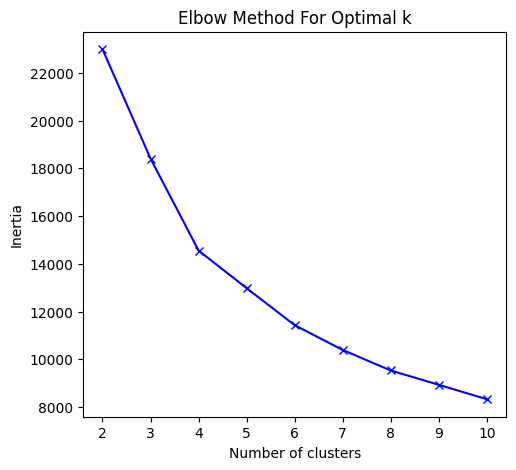

In [21]:
# KMeans to find GIDP batted ball profile clusters
# Using exit speed, vertical exit angle, horizontal exit angle
X = dps[['ExitSpeed', 'VExitAngle', 'HExitAngle']].dropna()
# Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Determine optimal number of clusters using the elbow method and silhouette score
inertia = []
silhouette_scores = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plotting the elbow method
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')

In [22]:
k = 5
kmeans_overall = KMeans(n_clusters=k, n_init=50, random_state=42)
X['Cluster'] = kmeans_overall.fit_predict(X_scaled)

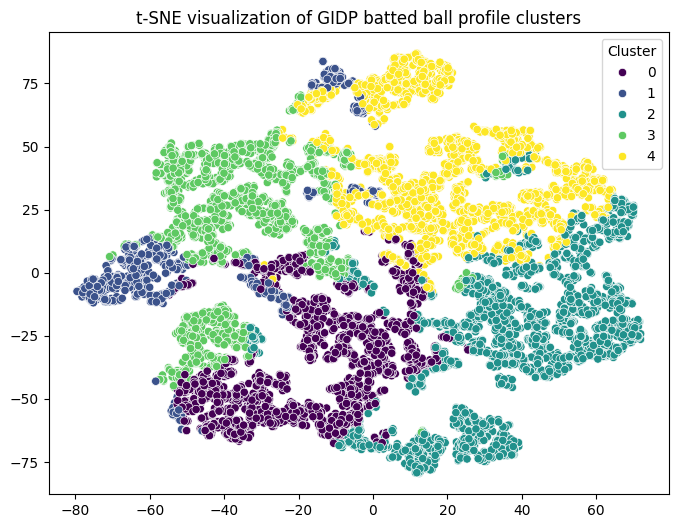

In [23]:
# Plotting with the clusters with tSNE

tsne = TSNE(
    n_components=2, # 2D projection
    perplexity=40, # 30-50 is good here
    random_state=1236,
    n_jobs=-1
)

X_tsne = tsne.fit_transform(X_scaled)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=X['Cluster'], palette='viridis')
plt.title('t-SNE visualization of GIDP batted ball profile clusters')
plt.show()

## Exploring Each Cluster

In [24]:
# Right-handed clusters

RHH_cluster_0 = X_right[X_right['Cluster'] == 0]
RHH_cluster_1 = X_right[X_right['Cluster'] == 1]
RHH_cluster_2 = X_right[X_right['Cluster'] == 2]
RHH_cluster_3 = X_right[X_right['Cluster'] == 3]


# Left-handed clusters
LHH_cluster_0 = X_left[X_left['Cluster'] == 0]
LHH_cluster_1 = X_left[X_left['Cluster'] == 1]
LHH_cluster_2 = X_left[X_left['Cluster'] == 2]
LHH_cluster_3 = X_left[X_left['Cluster'] == 3]

# Cluster summaries for RHH
for i in range(4):
    cluster = X_right[X_right['Cluster'] == i]
    print(f"RHH Cluster {i}:")
    print(cluster.describe())
    print("\n")

for j in range(4):
    cluster = X_left[X_left['Cluster'] == j]
    print(f"LHH Cluster {j}:")
    print(cluster.describe())
    print("\n")

RHH Cluster 0:
         ExitSpeed   VExitAngle   HExitAngle  Cluster
count  1552.000000  1552.000000  1552.000000   1552.0
mean     86.121655   -18.881657   -33.721516      0.0
std      10.401094     9.088373    10.760939      0.0
min      44.046710   -82.071480  -173.132600      0.0
25%      79.617230   -24.128577   -39.849818      0.0
50%      87.402610   -17.829730   -34.298575      0.0
75%      93.405385   -12.593958   -26.808160      0.0
max     110.140400     1.745070   -13.458490      0.0


RHH Cluster 1:
         ExitSpeed   VExitAngle   HExitAngle  Cluster
count  2677.000000  2677.000000  2677.000000   2677.0
mean     99.365633    -4.850142   -14.181080      1.0
std       5.747214     7.011172    12.890473      0.0
min      85.199830   -26.713250   -42.847060      1.0
25%      95.161410    -9.686825   -21.125510      1.0
50%      99.600560    -4.070016   -14.615790      1.0
75%     103.482600     0.582191    -7.606992      1.0
max     118.319200     9.480888    33.365910      

### Visualizations of Clusters

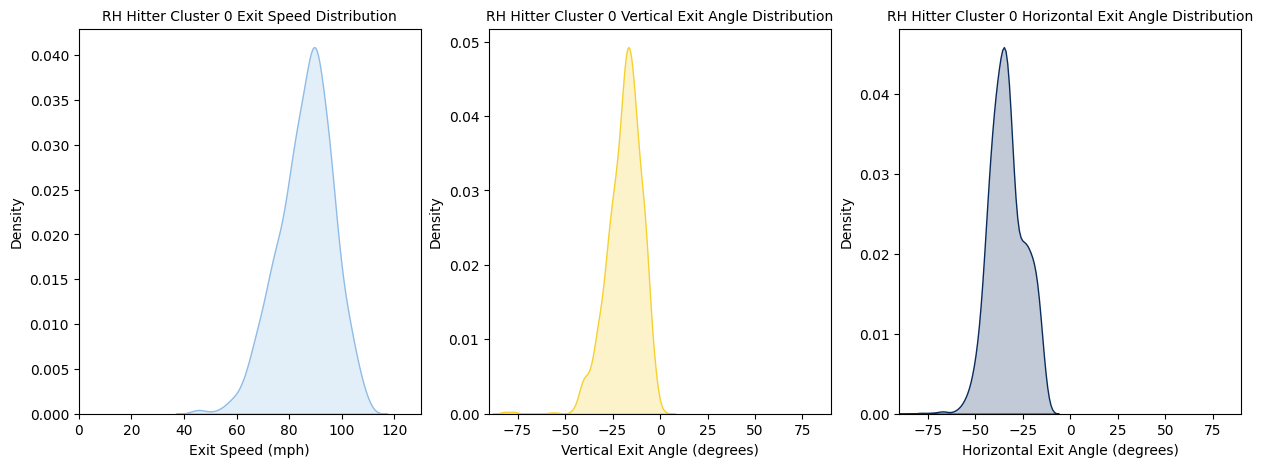

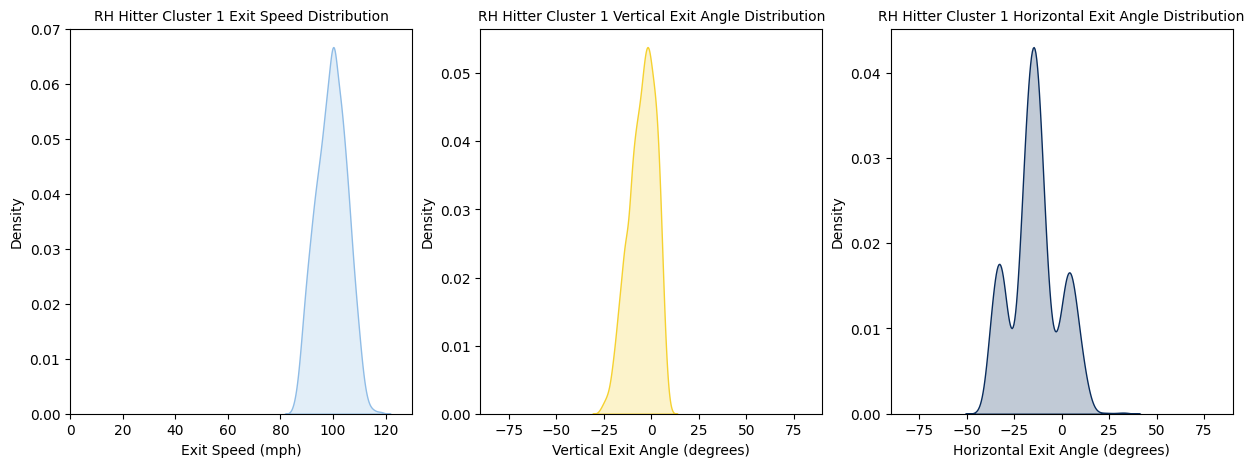

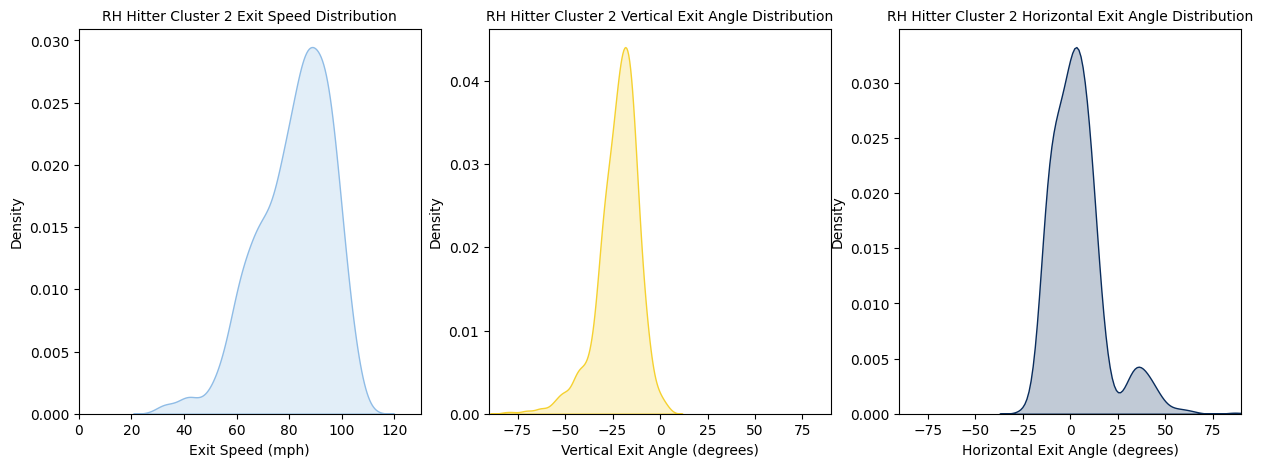

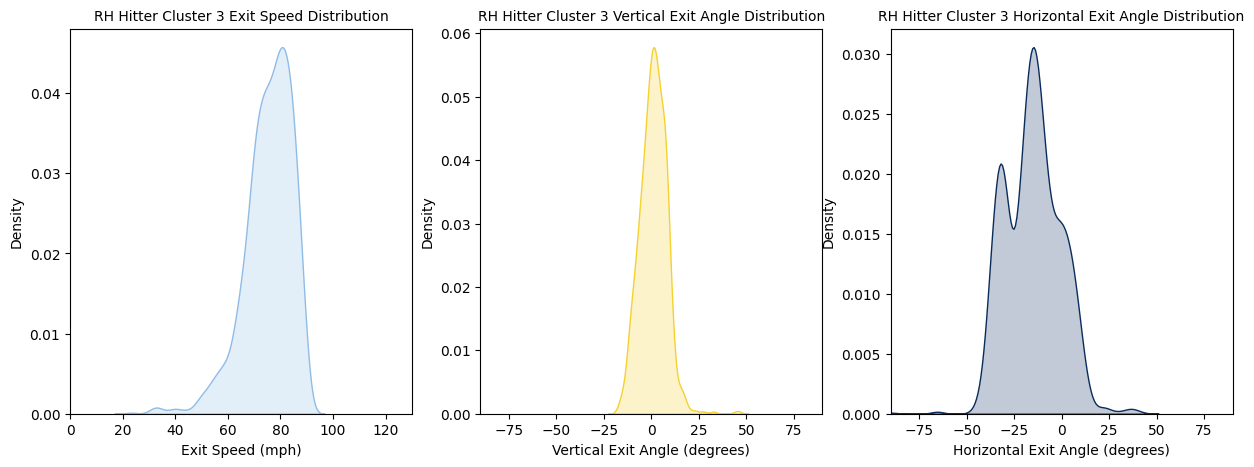

In [25]:
# Plotting densities for each cluster RHH

for i in range(4):
    cluster = X_right[X_right['Cluster'] == i]
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3,  1)
    sns.kdeplot(cluster['ExitSpeed'], fill=True, color='#8FBCE6')
    plt.title(f'RH Hitter Cluster {i} Exit Speed Distribution', fontsize=10)
    plt.xlabel('Exit Speed (mph)')
    plt.xlim(0, 130)
    plt.subplot(1, 3, 2)
    sns.kdeplot(cluster['VExitAngle'], fill=True, color='#F5D130')
    plt.title(f'RH Hitter Cluster {i} Vertical Exit Angle Distribution', fontsize=10)
    plt.xlabel('Vertical Exit Angle (degrees)')
    plt.xlim(-90, 90)
    plt.subplot(1, 3, 3)
    sns.kdeplot(cluster['HExitAngle'], fill=True, color='#092C5C')
    plt.title(f'RH Hitter Cluster {i} Horizontal Exit Angle Distribution', fontsize=10)
    plt.xlabel('Horizontal Exit Angle (degrees)')
    plt.xlim(-90, 90)
    plt.show()

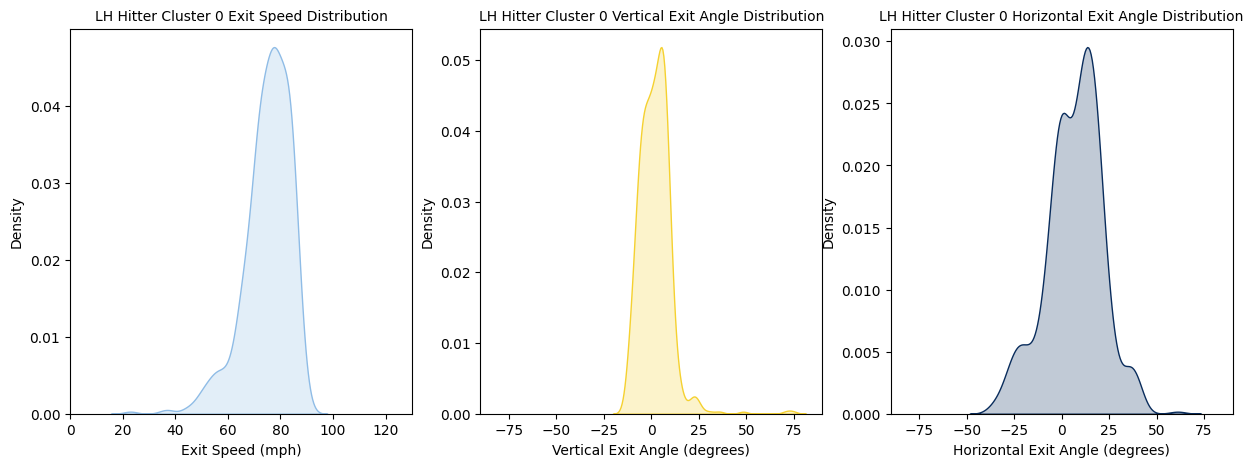

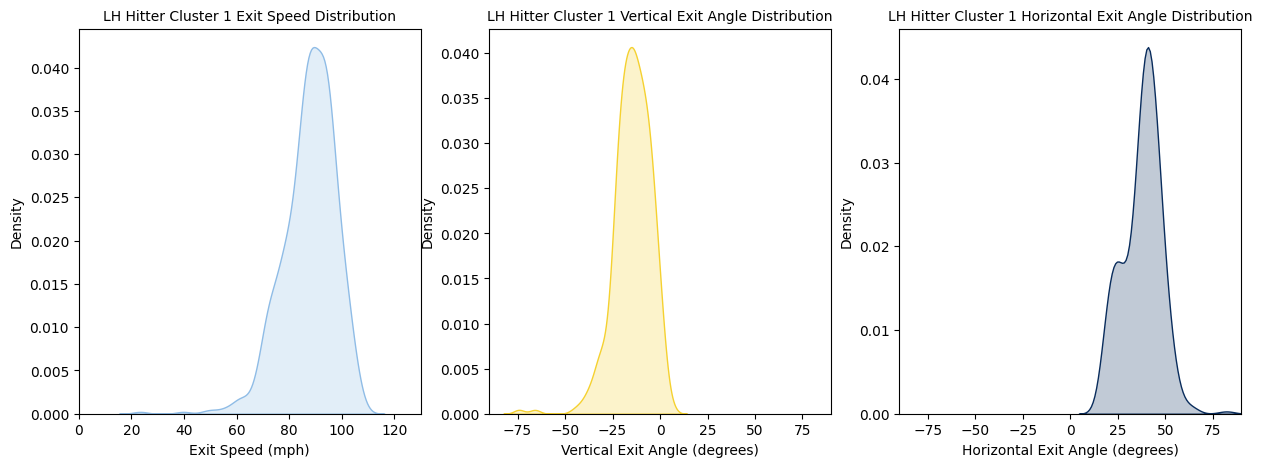

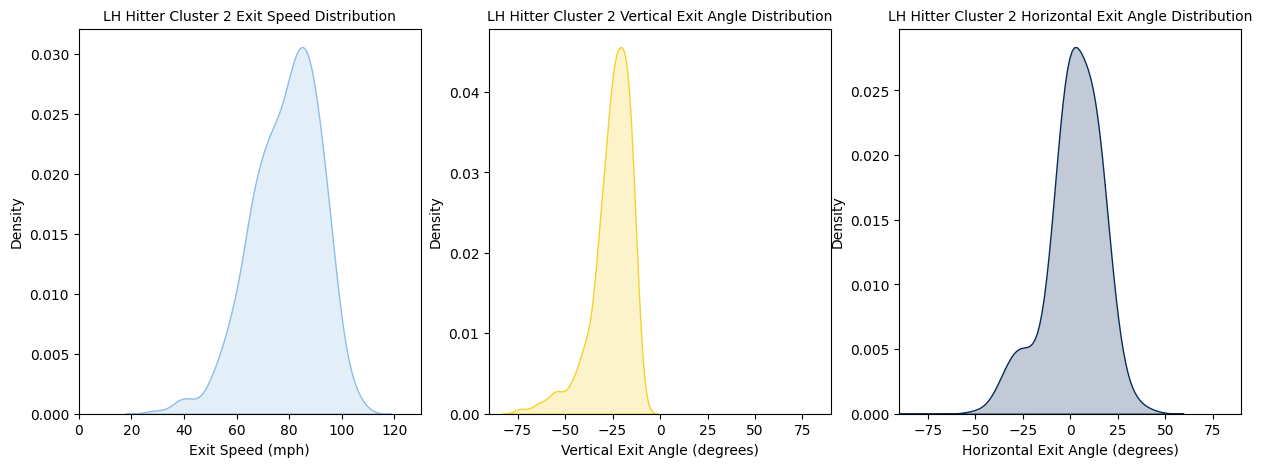

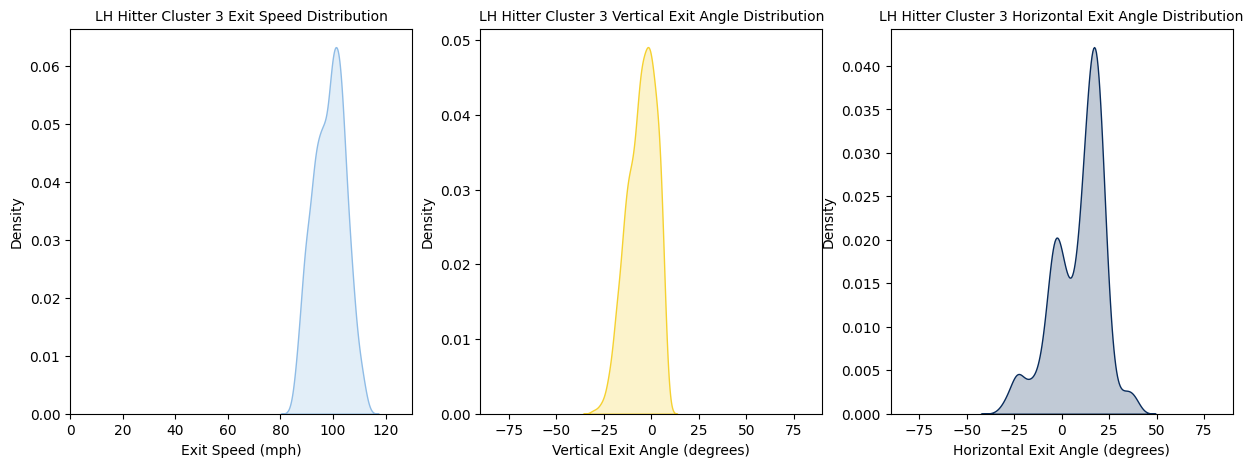

In [37]:
# Plotting densities for each cluster (LHH)

for j in range(4):
    cluster = X_left[X_left['Cluster'] == j]
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    sns.kdeplot(cluster['ExitSpeed'], fill=True, color='#8FBCE6')
    plt.title(f'LH Hitter Cluster {j} Exit Speed Distribution', fontsize=10)
    plt.xlabel('Exit Speed (mph)')
    plt.xlim(0, 130)
    plt.subplot(1, 3, 2)
    sns.kdeplot(cluster['VExitAngle'], fill=True, color='#F5D130')
    plt.title(f'LH Hitter Cluster {j} Vertical Exit Angle Distribution', fontsize=10)
    plt.xlabel('Vertical Exit Angle (degrees)')
    plt.xlim(-90, 90)
    plt.subplot(1, 3, 3)
    sns.kdeplot(cluster['HExitAngle'], fill=True, color='#092C5C')
    plt.title(f'LH Hitter Cluster {j} Horizontal Exit Angle Distribution', fontsize=10)
    plt.xlabel('Horizontal Exit Angle (degrees)')
    plt.xlim(-90, 90)
    plt.show()

In [26]:
# Converting right, left handed dataframes to CSVs for export
X_right.to_csv('RHH_GIDP_ByCluster.csv', index=False)
X_left.to_csv('LHH_GIDP_ByCluster.csv', index=False)

In [27]:
# Cluster Centers for Right, Left, Overall
print("RHH Cluster Centers:")
print(scaler_right.inverse_transform(kmeans_right.cluster_centers_))
print("\nLHH Cluster Centers:")
print(scaler_left.inverse_transform(kmeans_left.cluster_centers_))
print("\nOverall Cluster Centers:")
print(scaler.inverse_transform(kmeans_overall.cluster_centers_))

RHH Cluster Centers:
[[ 86.16527538 -18.82063588 -33.7145816 ]
 [ 99.37294918  -4.84541348 -14.13193427]
 [ 81.78293892 -22.23231858   4.08686438]
 [ 75.34863586   1.01234285 -15.18619346]]

LHH Cluster Centers:
[[ 74.93667019   1.94308248   6.66476166]
 [ 87.59216297 -14.60284926  38.37646882]
 [ 78.73517857 -25.5285728    0.99526452]
 [ 98.55103375  -5.14815172   8.99503865]]

Overall Cluster Centers:
[[ 88.97244423 -20.48261348 -24.99704906]
 [ 69.91975799 -28.62909125   9.48391388]
 [ 98.74720178  -2.95492216 -17.61532258]
 [ 74.10530341   0.61437865 -10.29987164]
 [ 94.80783927  -8.51540138  19.04951883]]


## Given the Cluster Centers, Find Sweet Spot:

In [28]:
# Middle 80% of All 3 Variables as Sweet Spot for each GIDP Profile
# RIGHT HANDED
# Cluster 0
mid_50_right_0_ev = np.percentile(RHH_cluster_0['ExitSpeed'], [10, 90], axis=0)
mid_50_right_0_vla = np.percentile(RHH_cluster_0['VExitAngle'], [10, 90], axis=0)
mid_50_right_0_hla = np.percentile(RHH_cluster_0['HExitAngle'], [10, 90], axis=0)
# [EV, VLA, HLA]
sweet_spot_right_0 = [mid_50_right_0_ev, mid_50_right_0_vla, mid_50_right_0_hla]
# Cluster 1
mid_50_right_1_ev = np.percentile(RHH_cluster_1['ExitSpeed'], [10, 90], axis=0)
mid_50_right_1_vla = np.percentile(RHH_cluster_1['VExitAngle'], [10, 90], axis=0)
mid_50_right_1_hla = np.percentile(RHH_cluster_1['HExitAngle'], [10, 90], axis=0)
# [EV, VLA, HLA]
sweet_spot_right_1 = [mid_50_right_1_ev, mid_50_right_1_vla, mid_50_right_1_hla]
# Cluster 2
mid_50_right_2_ev = np.percentile(RHH_cluster_2['ExitSpeed'], [10, 90], axis=0)
mid_50_right_2_vla = np.percentile(RHH_cluster_2['VExitAngle'], [10, 90], axis=0)
mid_50_right_2_hla = np.percentile(RHH_cluster_2['HExitAngle'], [10, 90], axis=0)
# [EV, VLA, HLA]
sweet_spot_right_2 = [mid_50_right_2_ev, mid_50_right_2_vla, mid_50_right_2_hla]
# Cluster 3
mid_50_right_3_ev = np.percentile(RHH_cluster_3['ExitSpeed'], [10, 90], axis=0)
mid_50_right_3_vla = np.percentile(RHH_cluster_3['VExitAngle'], [10, 90], axis=0)
mid_50_right_3_hla = np.percentile(RHH_cluster_3['HExitAngle'], [10, 90], axis=0)
# [EV, VLA, HLA]
sweet_spot_right_3 = [mid_50_right_3_ev, mid_50_right_3_vla, mid_50_right_3_hla]

# LEFT HANDED
# Cluster 0
mid_50_left_0_ev = np.percentile(LHH_cluster_0['ExitSpeed'], [10, 90], axis=0)
mid_50_left_0_vla = np.percentile(LHH_cluster_0['VExitAngle'], [10, 90], axis=0)
mid_50_left_0_hla = np.percentile(LHH_cluster_0['HExitAngle'], [10, 90], axis=0)
# [EV, VLA, HLA]
sweet_spot_left_0 = [mid_50_left_0_ev, mid_50_left_0_vla, mid_50_left_0_hla]
# Cluster 1
mid_50_left_1_ev = np.percentile(LHH_cluster_1['ExitSpeed'], [10, 90], axis=0)
mid_50_left_1_vla = np.percentile(LHH_cluster_1['VExitAngle'], [10, 90], axis=0)
mid_50_left_1_hla = np.percentile(LHH_cluster_1['HExitAngle'], [10, 90], axis=0)
# [EV, VLA, HLA]
sweet_spot_left_1 = [mid_50_left_1_ev, mid_50_left_1_vla, mid_50_left_1_hla]
# Cluster 2
mid_50_left_2_ev = np.percentile(LHH_cluster_2['ExitSpeed'], [10, 90], axis=0)
mid_50_left_2_vla = np.percentile(LHH_cluster_2['VExitAngle'], [10, 90], axis=0)
mid_50_left_2_hla = np.percentile(LHH_cluster_2['HExitAngle'], [10, 90], axis=0)
# [EV, VLA, HLA]
sweet_spot_left_2 = [mid_50_left_2_ev, mid_50_left_2_vla, mid_50_left_2_hla]
# Cluster 3
mid_50_left_3_ev = np.percentile(LHH_cluster_3['ExitSpeed'], [10, 90], axis=0)
mid_50_left_3_vla = np.percentile(LHH_cluster_3['VExitAngle'], [10, 90], axis=0)
mid_50_left_3_hla = np.percentile(LHH_cluster_3['HExitAngle'], [10, 90], axis=0)
# [EV, VLA, HLA]
sweet_spot_left_3 = [mid_50_left_3_ev, mid_50_left_3_vla, mid_50_left_3_hla]

rhh_GIDP_sweet_spots = {
    'Cluster 0': sweet_spot_right_0,
    'Cluster 1': sweet_spot_right_1,
    'Cluster 2': sweet_spot_right_2,
    'Cluster 3': sweet_spot_right_3
}

lhh_GIDP_sweet_spots = {
    'Cluster 0': sweet_spot_left_0,
    'Cluster 1': sweet_spot_left_1,
    'Cluster 2': sweet_spot_left_2,
    'Cluster 3': sweet_spot_left_3

}

print("RHH GIDP Sweet Spots (25th to 75th Percentile Ranges):")
for cluster, ranges in rhh_GIDP_sweet_spots.items():
    print(f"{cluster}: Exit Speed {ranges[0]}, Vertical Launch Angle {ranges[1]}, Horizontal Launch Angle {ranges[2]}")
print("\nLHH GIDP Sweet Spots (25th to 75th Percentile Ranges):")
for cluster, ranges in lhh_GIDP_sweet_spots.items():
    print(f"{cluster}: Exit Speed {ranges[0]}, Vertical Launch Angle {ranges[1]}, Horizontal Launch Angle {ranges[2]}")

RHH GIDP Sweet Spots (25th to 75th Percentile Ranges):
Cluster 0: Exit Speed [71.826478 98.486125], Vertical Launch Angle [-30.646302   -8.1809735], Horizontal Launch Angle [-44.439125 -20.10135 ]
Cluster 1: Exit Speed [ 91.503252 106.80714 ], Vertical Launch Angle [-14.640746    3.7866784], Horizontal Launch Angle [-32.734876    4.7644908]
Cluster 2: Exit Speed [62.477488 97.839976], Vertical Launch Angle [-35.043813 -10.72497 ], Horizontal Launch Angle [-11.608352  17.402104]
Cluster 3: Exit Speed [64.135324 85.613944], Vertical Launch Angle [-8.1400314  8.8388861], Horizontal Launch Angle [-33.968526    3.8510228]

LHH GIDP Sweet Spots (25th to 75th Percentile Ranges):
Cluster 0: Exit Speed [64.363912 84.463644], Vertical Launch Angle [-7.4345796  9.7012342], Horizontal Launch Angle [-12.381022  22.618822]
Cluster 1: Exit Speed [74.236672 99.226006], Vertical Launch Angle [-25.482006   -3.1901688], Horizontal Launch Angle [22.672844 49.00901 ]
Cluster 2: Exit Speed [62.2861   94.189

# Feature Engineering Sweet-Spots on the entire dataset

We are just going to create a binary classifier problem (at least for now). 

We can always create a multi-class problem to determine whicn types of GIDP each pitch type induces the most.

In [29]:
# First, filter the main dataset to just balls put into play
bip_df = pitches_total_sorted[pitches_total_sorted['pitchresult_desc'].isin(
    ['Hit Into Play - Out(s)', 'Hit Into Play - Run(s)', 'Hit Into Play - No Out(s)'
     ])
 ].copy()

In [30]:
# Apply a function to determine if each batted ball falls within any of the sweet spots

def is_in_sweet_spot(row, sweet_spots_right=rhh_GIDP_sweet_spots, 
                     sweet_spots_left=lhh_GIDP_sweet_spots, **kwargs):
    '''
    Determines if a batted ball falls within any of the defined sweet spots
    for right-handed or left-handed hitters based on exit velocity, vertical launch angle,
    and horizontal launch angle. This essentially captures whether a batted ball
    has the characteristics of a typical GIDP batted ball profile (many types).

    Params:
    row: A row from the DataFrame
    Returns:
    bool: True if the batted ball falls within any sweet spot, False otherwise
    '''
    ev = row['ExitSpeed']
    vla = row['VExitAngle']
    hla = row['HExitAngle']
    if row['batterside'] == 'R':

        for cluster, ranges in sweet_spots_right.items():
            if (ranges[0][0] <= ev <= ranges[0][1] and
                ranges[1][0] <= vla <= ranges[1][1] and
                ranges[2][0] <= hla <= ranges[2][1]):
                return 1
            
    elif row['batterside'] == 'L':
        for cluster, ranges in sweet_spots_left.items():
            if (ranges[0][0] <= ev <= ranges[0][1] and
                ranges[1][0] <= vla <= ranges[1][1] and
                ranges[2][0] <= hla <= ranges[2][1]):
                return 1
    return 0



In [31]:
# Apply the function to create a new column 'GIDP_SweetSpot'
bip_df['GIDP_SweetSpot'] = bip_df.apply(is_in_sweet_spot, axis=1)

In [32]:
bip_df[bip_df['GIDP_SweetSpot'] == 1]

,gameid,GameDate,ab,pitchnum,inning,teambat,balls,strikes,outs,visscore,homscore,pitcher,pitcherthrows,batter,batterside,pitchresult,pitchresult_desc,eventtype,metrics_pitching_position,pitchname,pitchname_desc,spinrate,relspeed,horzbreak,inducedvertbreak,vertbreak,platelocside,platelocheight,ExitSpeed,VExitAngle,HExitAngle,initposx,initposy,initposz,hometeam_id,Home,awayteam_id,Visitor,venue_id,venue_name,video_broadcast,GIDP_SweetSpot
72,2022/04/07/cinmlb-atlmlb-1,08:00.0,23,2,3,1,1,0,0,3,0,"Mahle, Tyler",R,"Dickerson, Alex",L,X,Hit Into Play - Out(s),field_out,Windup,FC,Cutter,2504.690,87.75558,-0.466407,13.969530,-21.25273,0.215705,3.003594,93.51692,-14.245970,29.484490,-1.557,50,5.500,144,Atlanta Braves,113,Cincinnati Reds,4705,Truist Park,https://sporty-clips.mlb.com/R3hWZExfV0ZRVkV3d...,1
106,2022/04/07/cinmlb-atlmlb-1,08:00.0,30,4,4,0,0,2,1,3,1,"Fried, Max",L,"Farmer, Kyle",R,X,Hit Into Play - Out(s),field_out,Stretch,SI,Sinker,2274.470,95.06247,-7.167854,9.019536,-20.99168,-0.223374,2.862048,93.01332,-19.568790,-27.388610,1.006,50,6.063,144,Atlanta Braves,113,Cincinnati Reds,4705,Truist Park,https://sporty-clips.mlb.com/R3hWZExfV0ZRVkV3d...,1
160,2022/04/07/cinmlb-atlmlb-1,08:00.0,44,5,6,0,1,2,1,3,1,"Fried, Max",L,"Senzel, Nick",R,X,Hit Into Play - Out(s),field_out,Stretch,CH,Changeup,1535.936,85.87400,-10.628600,6.887133,-29.86612,0.723976,2.116141,81.31339,0.102749,-18.859120,1.495,50,5.713,144,Atlanta Braves,113,Cincinnati Reds,4705,Truist Park,https://sporty-clips.mlb.com/R3hWZExfV0ZRVkV3d...,1
165,2022/04/07/cinmlb-atlmlb-1,08:00.0,45,5,6,0,1,2,2,3,1,"Fried, Max",L,"Moustakas, Mike",L,D,Hit Into Play - No Out(s),single,Stretch,FF,Four-seam FB,2192.524,95.85588,-5.344104,13.869620,-15.80523,-0.164722,3.204435,99.02639,-11.892250,5.203362,0.813,50,6.062,144,Atlanta Braves,113,Cincinnati Reds,4705,Truist Park,https://sporty-clips.mlb.com/R3hWZExfV0ZRVkV3d...,1
176,2022/04/07/cinmlb-atlmlb-1,08:00.0,48,4,6,0,2,1,2,6,1,"McHugh, Collin",R,"India, John",R,D,Hit Into Play - No Out(s),single,Windup,SL,Slider,2801.610,79.24608,-13.127370,-0.153067,-43.45441,-0.204137,2.197771,96.75996,0.616955,-24.152530,-2.416,50,5.275,144,Atlanta Braves,113,Cincinnati Reds,4705,Truist Park,https://sporty-clips.mlb.com/R3hWZExfV0ZRVkV3d...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2128713,2024/09/30/nynmlb-atlmlb-2,15:00.0,16,8,2,1,2,2,2,0,1,"Lucchesi, Joey",L,"Harris, Michael",L,X,Hit Into Play - Out(s),field_out,Stretch,SI,Sinker,2175.905,90.36536,-16.843630,3.196155,-30.20281,0.234270,2.362903,86.34489,-16.421400,14.356980,2.685,50,5.237,144,Atlanta Braves,121,New York Mets,4705,Truist Park,https://sporty-clips.mlb.com/bkdSUWdfWGw0TUFRP...,1
2128740,2024/09/30/nynmlb-atlmlb-2,15:00.0,22,4,3,1,2,1,2,0,1,"Lucchesi, Joey",L,"Olson, Matt",L,X,Hit Into Play - Out(s),field_out,Unknown,SI,Sinker,2235.785,90.32095,-15.681540,3.336823,-30.35929,-0.162774,2.928914,95.83296,-21.250100,26.597690,2.372,50,5.682,144,Atlanta Braves,121,New York Mets,4705,Truist Park,https://sporty-clips.mlb.com/bkdSUWdfWGw0TUFRP...,1
2128758,2024/09/30/nynmlb-atlmlb-2,15:00.0,26,6,4,1,2,2,0,0,1,"Lucchesi, Joey",L,"Soler, Jorge",R,X,Hit Into Play - Out(s),field_out,Unknown,FC,Cutter,2157.856,90.20134,-4.574575,14.958460,-18.61462,-0.138734,3.178448,84.28036,-11.184290,-25.671660,1.996,50,5.867,144,Atlanta Braves,121,New York Mets,4705,Truist Park,https://sporty-clips.mlb.com/bkdSUWdfWGw0TUFRP...,1
2128808,2024/09/30/nynmlb-atlmlb-2,15:00.0,38,2,5,1,1,0,2,0,1,"Lucchesi, Joey",L,"Ozuna, Marcell",R,X,Hit Into Play - Out(s),field_out,Unknown,FC,Cutter,2183.119,89.04897,-2.247111,15.074550,-19.13238,-0.477639,2.838856,84.80871,-23.509770,-38.992400,2.074,50,5.883,144,Atlanta Braves,121,New York Mets,4705,Truist Park,https://sporty-clips.mlb.com/bkdSUWdfWGw0TUFRP...,1


In [33]:
yesses = bip_df[bip_df['GIDP_SweetSpot'] == 1].copy()

In [34]:
yesses[yesses['batterside'] == 'L']

,gameid,GameDate,ab,pitchnum,inning,teambat,balls,strikes,outs,visscore,homscore,pitcher,pitcherthrows,batter,batterside,pitchresult,pitchresult_desc,eventtype,metrics_pitching_position,pitchname,pitchname_desc,spinrate,relspeed,horzbreak,inducedvertbreak,vertbreak,platelocside,platelocheight,ExitSpeed,VExitAngle,HExitAngle,initposx,initposy,initposz,hometeam_id,Home,awayteam_id,Visitor,venue_id,venue_name,video_broadcast,GIDP_SweetSpot
72,2022/04/07/cinmlb-atlmlb-1,08:00.0,23,2,3,1,1,0,0,3,0,"Mahle, Tyler",R,"Dickerson, Alex",L,X,Hit Into Play - Out(s),field_out,Windup,FC,Cutter,2504.690,87.75558,-0.466407,13.969530,-21.252730,0.215705,3.003594,93.51692,-14.245970,29.484490,-1.557,50,5.500,144,Atlanta Braves,113,Cincinnati Reds,4705,Truist Park,https://sporty-clips.mlb.com/R3hWZExfV0ZRVkV3d...,1
165,2022/04/07/cinmlb-atlmlb-1,08:00.0,45,5,6,0,1,2,2,3,1,"Fried, Max",L,"Moustakas, Mike",L,D,Hit Into Play - No Out(s),single,Stretch,FF,Four-seam FB,2192.524,95.85588,-5.344104,13.869620,-15.805230,-0.164722,3.204435,99.02639,-11.892250,5.203362,0.813,50,6.062,144,Atlanta Braves,113,Cincinnati Reds,4705,Truist Park,https://sporty-clips.mlb.com/R3hWZExfV0ZRVkV3d...,1
353,2022/04/07/clemlb-kcamlb-1,10:00.0,14,2,3,0,1,0,0,0,0,"Greinke, Zack",R,"Kwan, Steven",L,X,Hit Into Play - Out(s),field_out,Stretch,CH,Changeup,1600.096,84.78437,14.945640,3.794823,-34.103870,-0.078423,1.993473,96.98177,1.179366,-6.371219,-1.048,50,6.074,118,Kansas City Royals,114,Cleveland Guardians,7,Kauffman Stadium,https://sporty-clips.mlb.com/N09rbHJfWGw0TUFRP...,1
428,2022/04/07/clemlb-kcamlb-1,10:00.0,32,4,5,0,1,2,2,1,0,"Greinke, Zack",R,"Gimenez, Andres",L,X,Hit Into Play - Out(s),field_out,Stretch,CU,Curveball,2536.934,71.20168,-10.886780,-11.747030,-65.900510,-1.097819,1.563388,69.72309,5.711064,9.116764,-1.120,50,6.276,118,Kansas City Royals,114,Cleveland Guardians,7,Kauffman Stadium,https://sporty-clips.mlb.com/N09rbHJfWGw0TUFRP...,1
550,2022/04/07/clemlb-kcamlb-1,10:00.0,63,3,8,1,2,0,2,1,2,"McKenzie, Triston",R,"Benintendi, Andrew",L,E,Hit Into Play - Run(s),single,Stretch,FF,Four-seam FB,2314.597,93.24654,2.652785,21.382130,-9.985964,0.065612,2.463080,102.97460,-2.359021,5.353366,-1.835,50,6.159,118,Kansas City Royals,114,Cleveland Guardians,7,Kauffman Stadium,https://sporty-clips.mlb.com/N09rbHJfWGw0TUFRP...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2128331,2024/09/30/nynmlb-atlmlb-1,10:00.0,1,6,1,0,2,2,0,0,0,"Schwellenbach, Spencer",R,"Lindor, Francisco",L,X,Hit Into Play - Out(s),field_out,Stretch,FF,Four-seam FB,2263.954,95.69844,2.335278,11.057100,-18.553300,0.295444,2.711528,75.80840,-4.394627,22.939490,-2.091,50,5.365,144,Atlanta Braves,121,New York Mets,4705,Truist Park,https://sporty-clips.mlb.com/UVd4eTFfWGw0TUFRP...,1
2128339,2024/09/30/nynmlb-atlmlb-1,10:00.0,4,2,1,1,0,1,0,0,0,"Megill, Tylor",R,"Harris, Michael",L,X,Hit Into Play - Out(s),field_out,Windup,SI,Sinker,2068.680,95.09485,14.633800,5.793184,-24.335080,-0.799769,1.948457,95.35823,-5.985007,-6.053827,-2.115,50,5.764,144,Atlanta Braves,121,New York Mets,4705,Truist Park,https://sporty-clips.mlb.com/UVd4eTFfWGw0TUFRP...,1
2128404,2024/09/30/nynmlb-atlmlb-1,10:00.0,20,7,3,1,2,2,0,0,0,"Megill, Tylor",R,"Harris, Michael",L,D,Hit Into Play - No Out(s),single,Stretch,CU,Curveball,2442.021,79.04049,-9.368031,-12.845820,-56.507400,-1.235885,2.442090,91.38507,-7.437780,6.893699,-2.121,50,5.909,144,Atlanta Braves,121,New York Mets,4705,Truist Park,https://sporty-clips.mlb.com/UVd4eTFfWGw0TUFRP...,1
2128713,2024/09/30/nynmlb-atlmlb-2,15:00.0,16,8,2,1,2,2,2,0,1,"Lucchesi, Joey",L,"Harris, Michael",L,X,Hit Into Play - Out(s),field_out,Stretch,SI,Sinker,2175.905,90.36536,-16.843630,3.196155,-30.202810,0.234270,2.362903,86.34489,-16.421400,14.356980,2.685,50,5.237,144,Atlanta Braves,121,New York Mets,4705,Truist Park,https://sporty-clips.mlb.com/bkdSUWdfWGw0TUFRP...,1

In [35]:
bip_df_in_common = yesses.merge(
    dps[["gameid", "ab"]],
    on=["gameid", "ab"],
    how="inner"
)


In [36]:
bip_df_in_common

,gameid,GameDate,ab,pitchnum,inning,teambat,balls,strikes,outs,visscore,homscore,pitcher,pitcherthrows,batter,batterside,pitchresult,pitchresult_desc,eventtype,metrics_pitching_position,pitchname,pitchname_desc,spinrate,relspeed,horzbreak,inducedvertbreak,vertbreak,platelocside,platelocheight,ExitSpeed,VExitAngle,HExitAngle,initposx,initposy,initposz,hometeam_id,Home,awayteam_id,Visitor,venue_id,venue_name,video_broadcast,GIDP_SweetSpot
0,2022/04/07/clemlb-kcamlb-1,10:00.0,2,2,1,0,0,1,0,0,0,"Greinke, Zack",R,"Rosario, Amed",R,X,Hit Into Play - Out(s),grounded_into_double_play,Stretch,SL,Slider,2182.046,84.92921,-4.482286,4.856304,-32.65087,0.235638,1.935225,98.10506,-7.327979,2.281181,-1.132,50,6.100,118,Kansas City Royals,114,Cleveland Guardians,7,Kauffman Stadium,https://sporty-clips.mlb.com/N09rbHJfWGw0TUFRP...,1
1,2022/04/07/houmlb-anamlb-1,38:00.0,8,4,1,1,2,1,1,0,0,"Valdez, Framber",L,"Rendon, Anthony",R,X,Hit Into Play - Out(s),grounded_into_double_play,Stretch,SI,Sinker,2096.595,92.90878,-11.515430,5.122625,-26.44516,0.637365,1.679411,80.24135,-25.792980,-26.002420,0.990,50,5.847,108,Los Angeles Angels,117,Houston Astros,1,Angel Stadium,https://sporty-clips.mlb.com/d3owa2xfWGw0TUFRP...,1
2,2022/04/07/houmlb-anamlb-1,38:00.0,50,8,7,1,3,2,0,1,0,"Valdez, Framber",L,"Rendon, Anthony",R,X,Hit Into Play - Out(s),grounded_into_double_play,Stretch,SI,Sinker,2167.103,92.54595,-14.048440,3.845213,-28.08639,0.835854,1.531198,81.20807,-4.470048,3.332733,1.002,50,5.799,108,Los Angeles Angels,117,Houston Astros,1,Angel Stadium,https://sporty-clips.mlb.com/d3owa2xfWGw0TUFRP...,1
3,2022/04/07/houmlb-anamlb-1,38:00.0,69,4,9,1,1,2,1,3,1,"Pressly, Ryan",R,"Wade, Tyler",L,X,Hit Into Play - Out(s),grounded_into_double_play,Stretch,CU,Curveball,3219.702,78.89687,-17.657100,-14.187480,-58.77470,-0.047815,0.913844,91.74129,1.790855,20.308360,-0.455,50,6.042,108,Los Angeles Angels,117,Houston Astros,1,Angel Stadium,https://sporty-clips.mlb.com/d3owa2xfWGw0TUFRP...,1
4,2022/04/07/milmlb-chnmlb-1,20:00.0,35,1,5,0,0,0,0,1,0,"Hendricks, Kyle",R,"Adames, Willy",R,X,Hit Into Play - Out(s),grounded_into_double_play,Stretch,SI,Sinker,1910.131,86.17449,12.278560,7.304930,-29.33209,-0.926768,2.215030,94.55424,-4.470330,-28.709340,-2.019,50,6.140,112,Chicago Cubs,158,Milwaukee Brewers,17,Wrigley Field,https://sporty-clips.mlb.com/bzUwZFhfWGw0TUFRP...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5131,2024/09/29/slnmlb-sfnmlb-1,05:00.0,59,3,7,1,1,1,1,6,1,"McGreevy, Michael",R,"Casali, Curt",R,X,Hit Into Play - Out(s),grounded_into_double_play,Stretch,SL,Slider,2409.702,82.59856,-10.278080,-1.663122,-41.69758,0.204075,3.027555,80.86087,-10.895340,6.943757,-2.579,50,5.687,137,San Francisco Giants,138,St. Louis Cardinals,2395,Oracle Park,https://sporty-clips.mlb.com/anFMWDFfWGw0TUFRP...,1
5132,2024/09/29/tbamlb-bosmlb-1,05:00.0,43,1,5,1,0,0,1,1,3,"Montgomery, Mason",L,"Abreu, Wilyer",L,X,Hit Into Play - Out(s),grounded_into_double_play,Stretch,FF,Four-seam FB,2229.874,97.55892,-6.959518,18.442280,-10.41051,0.735022,2.072292,75.40738,2.607460,-1.994081,1.421,50,5.731,111,Boston Red Sox,139,Tampa Bay Rays,3,Fenway Park,https://sporty-clips.mlb.com/MzVEYlJfWGw0TUFRP...,1
5133,2024/09/29/tbamlb-bosmlb-1,05:00.0,51,5,6,1,3,1,1,1,3,"Montgomery, Mason",L,"Gasper, Michael",R,X,Hit Into Play - Out(s),grounded_into_double_play,Stretch,FF,Four-seam FB,2181.907,96.70519,-6.605328,18.736040,-10.44100,-0.348687,2.696947,104.85040,-4.828938,-19.197270,1.220,50,5.658,111,Boston Red Sox,139,Tampa Bay Rays,3,Fenway Park,https://sporty-clips.mlb.com/MzVEYlJfWGw0TUFRP...,1
5134,2024/09/29/texmlb-anamlb-1,07:00.0,28,1,4,0,0,0,0,1,0,"Kochanowicz, Jack",R,"Taveras, Leody",L,X,Hit Into Play - Out(s),grounded_into_double_play,Stretch,SI,Sinker,2021.123,96.78059,16.806110,0.597919,-28.77710,0.199934,1.732457,92.81413,-10.298160,18.146480,-1.865,50,5.703,108,L

In [37]:
print(bip_df[["ExitSpeed", "VExitAngle", "HExitAngle", "batterside"]].head())


    ExitSpeed  VExitAngle  HExitAngle batterside
10   55.31276  -42.227200   -0.448136          R
19   91.72955   -0.069351   12.199050          R
21  100.97140   36.611920  -17.393650          R
31   98.19635    8.123025   -3.759704          R
34   69.13850   64.647930   -1.996992          L


Now that we have GIDP clusters, find sweet spots for each metric. But they are all dependent of eachother, so need to figure this out.

In [38]:
# Saving clusters to CSV
X_right.to_csv('RHH_GIDP_Clusters.csv', index=False)
X_left.to_csv('LHH_GIDP_Clusters.csv', index=False)

# Feature Engineering Different Pitch Archetypes -- "Curveball" is too general. Changeup low and away is MUCH different from changeups up and away. 

7286 games between '22 and '24

## Modeling

In [40]:
# Drop NA values for modeling
bip_df = bip_df.dropna()

### Utilizing a GAM

Going to create 4 different models depending on platoons: RHP v RHH, RHP v LHH, LHP v RHH, LHP v LHH

In [41]:
# Create four different subsets based on pitcher-batter handedness
RHP_RHH = bip_df[(bip_df['pitcherthrows'] == 'R') & (bip_df['batterside'] == 'R')]
RHP_LHH = bip_df[(bip_df['pitcherthrows'] == 'R') & (bip_df['batterside'] == 'L')]
LHP_RHH = bip_df[(bip_df['pitcherthrows'] == 'L') & (bip_df['batterside'] ==  'R')]
LHP_LHH = bip_df[(bip_df['pitcherthrows'] == 'L') & (bip_df['batterside'] == 'L')]

### RHP V RHH

In [43]:
X_RR = RHP_RHH[['spinrate', 'relspeed', 'horzbreak', 'inducedvertbreak',
            'vertbreak', 'platelocside', 'platelocheight', 'initposx', 'initposz']]
Y_RR = RHP_RHH['GIDP_SweetSpot']

X_train_RR, X_test_RR, y_train_RR, y_test_RR = train_test_split(
    np.array(X_RR), np.array(Y_RR),
    test_size=0.2,
    random_state=42,
    stratify=np.array(Y_RR)
)

# Grid search for best hyperparameters
gam_RR = LogisticGAM(s(0) + s(1) + te(2, 3, 4) + 
                   te(5, 6) + te(7, 8)).gridsearch(X_train_RR, y_train_RR)

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:02:16 ETA:   0:22:45
 18% (2 of 11) |####                     | Elapsed Time: 0:03:32 ETA:   0:15:57
 27% (3 of 11) |######                   | Elapsed Time: 0:04:46 ETA:   0:12:44
 36% (4 of 11) |#########                | Elapsed Time: 0:06:43 ETA:   0:11:45
 45% (5 of 11) |###########              | Elapsed Time: 0:07:53 ETA:   0:09:28
 54% (6 of 11) |#############            | Elapsed Time: 0:09:16 ETA:   0:07:43
 63% (7 of 11) |###############          | Elapsed Time: 0:10:57 ETA:   0:06:15
 72% (8 of 11) |##################       | Elapsed Time: 0:11:53 ETA:   0:04:27
 81% (9 of 11) |####################     | Elapsed Time: 0:12:50 ETA:   0:02:51
 90% (10 of 11) |#####################   | Elapsed Time: 0:14:09 ETA:   0:01:24
100% (11 of 11) |########################| Elapsed Time: 0:15:04 Time:  0:15:04


In [44]:
gam_RR.summary()


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     90.7854
Link Function:                        LogitLink Log Likelihood:                                -51077.9943
Number of Samples:                       115856 AIC:                                           102337.5595
                                                AICc:                                          102337.7066
                                                UBRE:                                               2.8839
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                    0.033
Feature Function                  Lam

/var/folders/zd/lzk6p4jx3j760xhr1rwpzsnm0000gn/T/ipykernel_6813/3326710108.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_RR.summary()


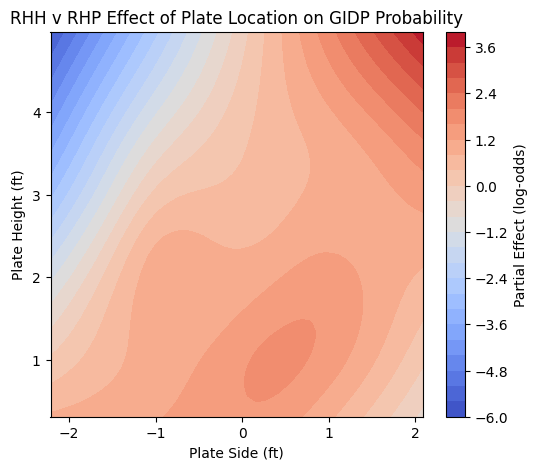

In [46]:
def create_zone_heatmap(gam, X_train, title_str='RHH v RHP'):
    '''
    Creates a heatmap to visualize the effect of plate location (side and height)
    on the probability of a GIDP occurring, based on the fitted GAM model.

    Params:
    gam_RR: Fitted LogisticGAM model
    X_train: Training feature set used for the model
    '''
    zone_idx = 3
    x_range = np.linspace(X_train[:, 5].min(), X_train[:, 5].max(), 50)  # plate side
    z_range = np.linspace(X_train[:, 6].min(), X_train[:, 6].max(), 50)  # plate height
    XX, ZZ = np.meshgrid(x_range, z_range)
    pdep = gam.partial_dependence(term=zone_idx, X=(XX, ZZ), meshgrid=True)
    plt.figure(figsize=(6, 5))
    plt.contourf(XX, ZZ, pdep, levels=30, cmap="coolwarm")
    plt.colorbar(label="Partial Effect (log-odds)")
    plt.xlabel("Plate Side (ft)")
    plt.ylabel("Plate Height (ft)")
    plt.title(f"{title_str} Effect of Plate Location on GIDP Probability")
    plt.show()


create_zone_heatmap(gam_RR, X_train_RR)

In [52]:
pred_probs_RR = gam_RR.predict_proba(X_test_RR)
pred_class_RR = gam_RR.predict(X_test_RR)

print("AUC:", roc_auc_score(y_test_RR, pred_probs_RR))
print("Accuracy:", accuracy_score(y_test_RR, pred_class_RR))

AUC: 0.6265338030438271
Accuracy: 0.8299613313078305


## RHP v LHH

In [53]:
X_RL = RHP_LHH[['spinrate', 'relspeed', 'horzbreak', 'inducedvertbreak',
            'vertbreak', 'platelocside', 'platelocheight', 'initposx', 'initposz']]
Y_RL = RHP_LHH['GIDP_SweetSpot']

X_train_RL, X_test_RL, y_train_RL, y_test_RL = train_test_split(
    np.array(X_RL), np.array(Y_RL),
    test_size=0.2,
    random_state=42,
    stratify=np.array(Y_RL)
)

# Grid search for best hyperparameters
gam_RL = LogisticGAM(s(0) + s(1) + te(2, 3, 4) + 
                   te(5, 6) + te(7, 8)).gridsearch(X_train_RL, y_train_RL)

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:03:59 ETA:   0:39:53
 18% (2 of 11) |####                     | Elapsed Time: 0:05:02 ETA:   0:22:41
 27% (3 of 11) |######                   | Elapsed Time: 0:06:06 ETA:   0:16:17
 36% (4 of 11) |#########                | Elapsed Time: 0:06:54 ETA:   0:12:05
 45% (5 of 11) |###########              | Elapsed Time: 0:07:43 ETA:   0:09:16
 54% (6 of 11) |#############            | Elapsed Time: 0:08:31 ETA:   0:07:06
 63% (7 of 11) |###############          | Elapsed Time: 0:09:22 ETA:   0:05:21
 72% (8 of 11) |##################       | Elapsed Time: 0:10:10 ETA:   0:03:48
 81% (9 of 11) |####################     | Elapsed Time: 0:11:00 ETA:   0:02:26
 90% (10 of 11) |#####################   | Elapsed Time: 0:11:47 ETA:   0:01:10
100% (11 of 11) |########################| Elapsed Time: 0:12:36 Time:  0:12:36


In [55]:
pred_probs_RL = gam_RL.predict_proba(X_test_RL)
pred_class_RL = gam_RL.predict(X_test_RL)

print("AUC:", roc_auc_score(y_test_RL, pred_probs_RL))
print("Accuracy:", accuracy_score(y_test_RL, pred_class_RL))

AUC: 0.6318197545556534
Accuracy: 0.8496091376726478


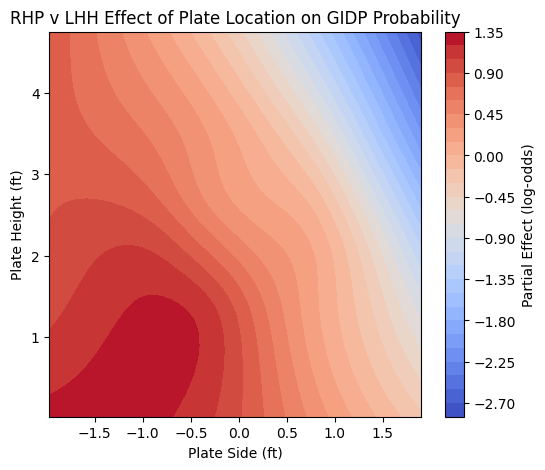

In [56]:
create_zone_heatmap(gam_RL, X_train_RL, "RHP v LHH")

## LHP v RHH

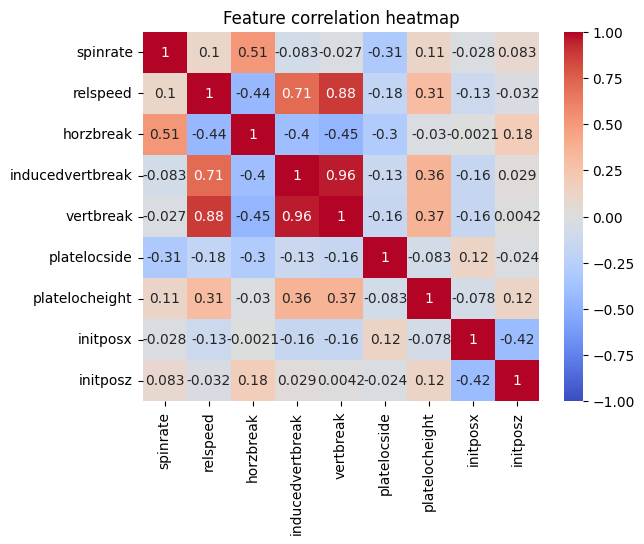

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = X_LR.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Feature correlation heatmap")
plt.show()


In [57]:
X_LR = LHP_RHH[['spinrate', 'relspeed', 'horzbreak', 'inducedvertbreak',
            'vertbreak', 'platelocside', 'platelocheight', 'initposx', 'initposz']]
Y_LR = LHP_RHH['GIDP_SweetSpot']

X_train_LR, X_test_LR, y_train_LR, y_test_LR = train_test_split(
    np.array(X_LR), np.array(Y_LR),
    test_size=0.2,
    random_state=42,
    stratify=np.array(Y_LR)
)

# Grid search for best hyperparameters
gam_LR = LogisticGAM(s(0) + s(1) + te(2, 3, 4) + 
                   te(5, 6) + te(7, 8)).gridsearch(X_train_LR, y_train_LR)

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:01:09 ETA:   0:11:36
 18% (2 of 11) |####                     | Elapsed Time: 0:01:53 ETA:   0:08:31
 27% (3 of 11) |######                   | Elapsed Time: 0:02:30 ETA:   0:06:40
 36% (4 of 11) |#########                | Elapsed Time: 0:03:06 ETA:   0:05:27
 45% (5 of 11) |###########              | Elapsed Time: 0:03:50 ETA:   0:04:36
 54% (6 of 11) |#############            | Elapsed Time: 0:04:38 ETA:   0:03:51
 63% (7 of 11) |###############          | Elapsed Time: 0:05:11 ETA:   0:02:58
 72% (8 of 11) |##################       | Elapsed Time: 0:05:44 ETA:   0:02:09
 81% (9 of 11) |####################     | Elapsed Time: 0:06:14 ETA:   0:01:23
 90% (10 of 11) |#####################   | Elapsed Time: 0:06:42 ETA:   0:00:40
100% (11 of 11) |########################| Elapsed Time: 0:07:10 Time:  0:07:10


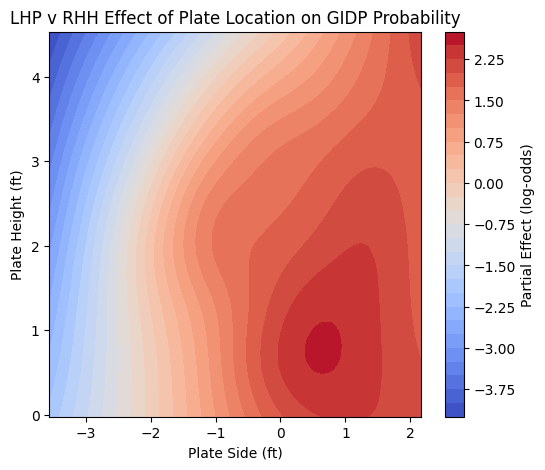

In [59]:
create_zone_heatmap(gam_LR, X_train_LR, "LHP v RHH")

In [58]:
pred_probs_LR = gam_LR.predict_proba(X_test_LR)
pred_class_LR = gam_LR.predict(X_test_LR)

print("AUC:", roc_auc_score(y_test_LR, pred_probs_LR))
print("Accuracy:", accuracy_score(y_test_LR, pred_class_LR))

AUC: 0.6273562154709046
Accuracy: 0.8426173347036656


## LHP V LHH

In [61]:
X_LL = LHP_LHH[['spinrate', 'relspeed', 'horzbreak', 'inducedvertbreak',
            'vertbreak', 'platelocside', 'platelocheight', 'initposx', 'initposz']]
Y_LL = LHP_LHH['GIDP_SweetSpot']

X_train_LL, X_test_LL, y_train_LL, y_test_LL = train_test_split(
    np.array(X_LL), np.array(Y_LL),
    test_size=0.2,
    random_state=42,
    stratify=np.array(Y_LL)
)

# Grid search for best hyperparameters
gam_LL = LogisticGAM(s(0) + s(1) + te(2, 3, 4) + 
                   te(5, 6) + te(7, 8)).gridsearch(X_train_LL, y_train_LL)

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:28 ETA:   0:04:42
 18% (2 of 11) |####                     | Elapsed Time: 0:00:47 ETA:   0:03:34
 27% (3 of 11) |######                   | Elapsed Time: 0:01:05 ETA:   0:02:55
 36% (4 of 11) |#########                | Elapsed Time: 0:01:23 ETA:   0:02:26
 45% (5 of 11) |###########              | Elapsed Time: 0:01:41 ETA:   0:02:01
 54% (6 of 11) |#############            | Elapsed Time: 0:02:00 ETA:   0:01:40
 63% (7 of 11) |###############          | Elapsed Time: 0:02:18 ETA:   0:01:19
 72% (8 of 11) |##################       | Elapsed Time: 0:02:32 ETA:   0:00:57
 81% (9 of 11) |####################     | Elapsed Time: 0:02:49 ETA:   0:00:37
 90% (10 of 11) |#####################   | Elapsed Time: 0:03:03 ETA:   0:00:18
100% (11 of 11) |########################| Elapsed Time: 0:03:16 Time:  0:03:16


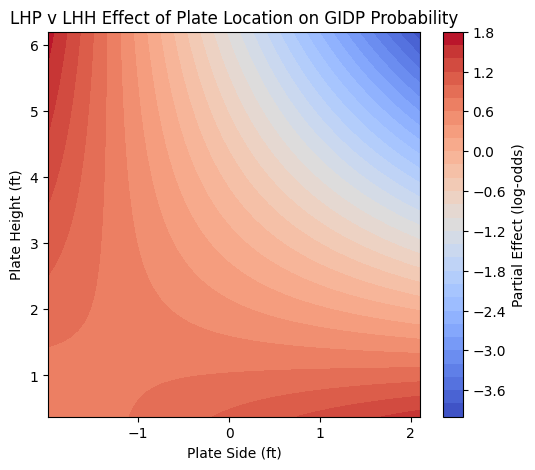

In [68]:
create_zone_heatmap(gam_LL, X_train_LL, "LHP v LHH")

In [63]:
pred_probs_LL = gam_LL.predict_proba(X_test_LL)
pred_class_LL = gam_LL.predict(X_test_LL)

print("AUC:", roc_auc_score(y_test_LL, pred_probs_LL))
print("Accuracy:", accuracy_score(y_test_LL, pred_class_LL))


AUC: 0.6196018266623005
Accuracy: 0.8362085308056872


# GAM with different smoothing surfaces

In [ ]:
# More GAM
X_RR_2 = RHP_RHH[['spinrate', 'relspeed', 'inducedvertbreak', 'horzbreak',
                'platelocside', 'platelocheight', 'initposx', 'initposz'] 
                ]
pitcher__RR = RHP_RHH['pitcher']
Y_RR = RHP_RHH['GIDP_SweetSpot']

X_train_RR_2, X_test_RR_2, y_train_RR_2, y_test_RR_2 = train_test_split(
    np.array(X_RR_2), np.array(Y_RR),
    test_size=0.2,
    random_state=42,
    stratify=np.array(Y_RR)
)

# Grid search for best hyperparameters
gam_RR_2 = LogisticGAM(
    te(0, 1, 2, n_splines=10) + # Interaction between spin rate, release speed, and induced vertical break
    te(2, 3, n_splines=10) + # Interaction between IVB and horizontal break
    te(4, 5, n_splines=10) + # Interaction between plate side and height
    te(6, 7, n_splines=10) # Interaction between initial position x and z
    ).gridsearch(X_train_RR_2, y_train_RR_2)

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:02:46 ETA:   0:27:47
 18% (2 of 11) |####                     | Elapsed Time: 0:04:48 ETA:   0:21:38
 27% (3 of 11) |######                   | Elapsed Time: 0:06:29 ETA:   0:17:19
 36% (4 of 11) |#########                | Elapsed Time: 0:07:51 ETA:   0:13:45
 45% (5 of 11) |###########              | Elapsed Time: 0:12:35 ETA:   0:15:06
 54% (6 of 11) |#############            | Elapsed Time: 0:13:53 ETA:   0:11:34
 63% (7 of 11) |###############          | Elapsed Time: 0:14:56 ETA:   0:08:32
 72% (8 of 11) |##################       | Elapsed Time: 2:21:42 ETA:   0:53:08
 81% (9 of 11) |####################     | Elapsed Time: 2:23:23 ETA:   0:31:51
 90% (10 of 11) |#####################   | Elapsed Time: 2:24:42 ETA:   0:14:28
100% (11 of 11) |########################| Elapsed Time: 2:25:58 Time:  2:25:58


In [73]:
pred_probs_RR_2 = gam_RR_2.predict_proba(X_test_RR_2)
pred_class_RR_2 = gam_RR_2.predict(X_test_RR_2)
print("AUC:", roc_auc_score(y_test_RR_2, pred_probs_RR_2))
print("Accuracy:", accuracy_score(y_test_RR_2, pred_class_RR_2))

AUC: 0.6263782858776654
Accuracy: 0.8299613313078305


In [74]:
gam_RR_2.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     61.3167
Link Function:                        LogitLink Log Likelihood:                                -51121.9073
Number of Samples:                       115856 AIC:                                           102366.4479
                                                AICc:                                          102366.5161
                                                UBRE:                                                2.884
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0322
Feature Function                  Lam

/var/folders/zd/lzk6p4jx3j760xhr1rwpzsnm0000gn/T/ipykernel_6813/2031045699.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_RR_2.summary()


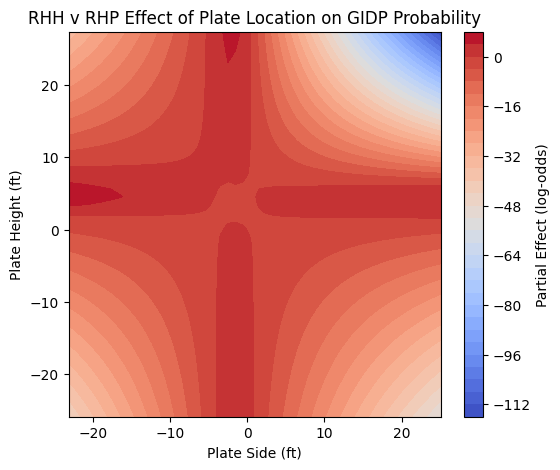

In [85]:
def create_movement_heatmap(gam, X_train, title_str='RHH v RHP'):
    '''
    Creates a heatmap to visualize the effect of plate location (side and height)
    on the probability of a GIDP occurring, based on the fitted GAM model.

    Params:
    gam_RR: Fitted LogisticGAM model
    X_train: Training feature set used for the model
    '''
    zone_idx = 3
    x_range = np.linspace(X_train[:, 2].min(), X_train[:, 2].max(), 50)  # plate side
    z_range = np.linspace(X_train[:, 3].min(), X_train[:, 3].max(), 50)  # plate height
    XX, ZZ = np.meshgrid(x_range, z_range)
    pdep = gam.partial_dependence(term=zone_idx, X=(XX, ZZ), meshgrid=True)
    plt.figure(figsize=(6, 5))
    plt.contourf(XX, ZZ, pdep, levels=30, cmap="coolwarm")
    plt.colorbar(label="Partial Effect (log-odds)")
    plt.xlabel("Plate Side (ft)")
    plt.ylabel("Plate Height (ft)")
    plt.title(f"{title_str} Effect of Plate Location on GIDP Probability")
    plt.show()

create_movement_heatmap(gam_RR_2, X_train_RR_2)

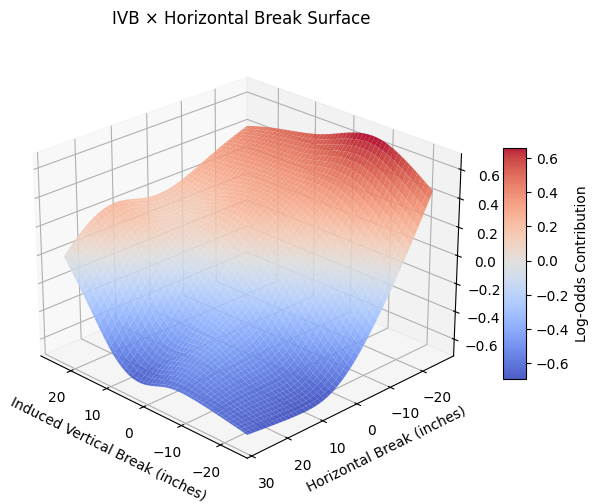

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# ---- 1. Generate flat grid of data points ----
term = 1  # IVB × Horizontal Break
Xflat = gam_RR_2.generate_X_grid(term=term)     # shape (n_points, n_features)
pdep  = gam_RR_2.partial_dependence(term=term, X=Xflat)

# ---- 2. Identify which columns belong to this smooth ----
# For term=1, that’s IVB (2) and horzbreak (3)
ivb_vals  = Xflat[:, 2]
hb_vals   = Xflat[:, 3]
z_vals    = pdep

# ---- 3. Build 2D grid manually ----
ivb_unique = np.unique(ivb_vals)
hb_unique  = np.unique(hb_vals)
Xgrid, Ygrid = np.meshgrid(ivb_unique, hb_unique)

# Need to reshape z-values into (len(hb_unique), len(ivb_unique))
Zgrid = z_vals.reshape(len(hb_unique), len(ivb_unique))

# ---- 4. Plot the surface ----
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(Xgrid, Ygrid, Zgrid,
                       cmap='coolwarm',
                       linewidth=0,
                       antialiased=True,
                       edgecolor='none',
                       alpha=0.9)

ax.set_xlabel("Induced Vertical Break (inches)")
ax.set_ylabel("Horizontal Break (inches)")
ax.set_zlabel("Effect on Log-Odds")
ax.set_title("IVB × Horizontal Break Surface")
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label="Log-Odds Contribution")

ax.view_init(elev=25, azim=135)  # optional: better camera angle
plt.show()
